# Bollinger Bands Mean-Reversion Strategy (BQFG Assignment)

**Author:** Lalit Boyapati

This notebook implements a classic **mean-reversion** strategy using **Bollinger Bands**:

- **Buy** when price closes **below the lower band** (oversold) and exit when price crosses back above the middle band (SMA).
- **Short** when price closes **above the upper band** (overbought) and exit when price crosses back below the middle band.
- Includes configurable **transaction costs**, **position sizing**, and **risk controls** (optional stop-loss / take-profit).
- Produces performance metrics (Sharpe, Max Drawdown, CAGR, Win rate, etc.) and plots.



In [1]:
# === Imports ===
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True

print('Libraries imported.')

Libraries imported.


In [2]:
# === Config ===
TICKER = 'SPY'            # Ticker symbol
START  = '2015-01-01'     # Start date
END    = '2025-09-15'     # End date

# Bollinger Bands params
BB_WINDOW = 20            # lookback window for SMA & std
BB_K      = 2.0           # number of std deviations for bands

# Backtest params
INIT_CASH = 100_000
LEVERAGE  = 1.0           # 1.0 = fully cash-backed
COST_BPS  = 2             # roundtrip cost expressed per **trade entry or exit** in basis points (1 bps = 0.01%)
ALLOW_SHORTS = True
RISK_STOP_LOSS_PCT = None  # e.g., 0.05 for 5% from entry; None to disable
TAKE_PROFIT_PCT  = None    # e.g., 0.05 for 5% from entry; None to disable

SEED = 1337               # for synthetic data fallback

print('Configured.')

Configured.


## Data Loading


In [3]:
def load_data(ticker: str, start: str, end: str, seed: int = 42) -> pd.DataFrame:
    try:
        import yfinance as yf
        df = yf.download(ticker, start=start, end=end, progress=False)
        if df is None or df.empty:
            raise RuntimeError('Empty data fetched from yfinance.')
        df = df[['Open','High','Low','Close','Adj Close','Volume']].copy()
        df.index = pd.to_datetime(df.index)
        return df
    except Exception as e:
        print('yfinance unavailable or failed ({}). Generating synthetic GBM data...'.format(e))
        np.random.seed(seed)
        dates = pd.date_range(start=start, end=end, freq='B')
        n = len(dates)
        mu, sigma = 0.08, 0.20  # annual drift & vol
        dt = 1/252
        shocks = np.random.normal((mu - 0.5*sigma**2)*dt, sigma*np.sqrt(dt), size=n)
        price = 100*np.exp(np.cumsum(shocks))
        close = price
        high  = close * (1 + np.random.uniform(0, 0.01, size=n))
        low   = close * (1 - np.random.uniform(0, 0.01, size=n))
        open_ = close * (1 + np.random.uniform(-0.005, 0.005, size=n))
        vol   = np.random.randint(1e6, 3e6, size=n)
        df = pd.DataFrame({'Open':open_, 'High':high, 'Low':low, 'Close':close,
                           'Adj Close':close, 'Volume':vol}, index=dates)
        return df

prices = load_data(TICKER, START, END, seed=SEED)
assert not prices.empty, 'No data.'
prices.tail()

yfinance unavailable or failed ("['Adj Close'] not in index"). Generating synthetic GBM data...


,Open,High,Low,Close,Adj Close,Volume
2025-09-09,242.253676,243.555610,241.856220,243.141540,243.141540,1236700
2025-09-10,241.335403,241.656123,239.914402,240.868075,240.868075,1585189
2025-09-11,238.782317,238.286081,236.035569,237.950250,237.950250,2908014
2025-09-12,244.104029,244.603632,242.685275,243.308248,243.308248,2990703
2025-09-15,242.564517,242.551401,240.639229,242.051621,242.051621,1017204


## Indicators: Bollinger Bands
Middle band is an SMA; upper/lower bands are `SMA ± K·σ`. Signals:
- **Long Entry**: Close < Lower Band
- **Long Exit**: Close crosses above Middle Band
- **Short Entry**: Close > Upper Band (if `ALLOW_SHORTS=True`)
- **Short Exit**: Close crosses below Middle Band

In [4]:
def compute_bollinger(df: pd.DataFrame, window: int, k: float) -> pd.DataFrame:
    out = df.copy()
    out['sma'] = out['Close'].rolling(window).mean()
    out['std'] = out['Close'].rolling(window).std(ddof=0)
    out['upper'] = out['sma'] + k * out['std']
    out['lower'] = out['sma'] - k * out['std']
    return out

ind = compute_bollinger(prices, BB_WINDOW, BB_K)
ind = ind.dropna().copy()
ind.tail()

,Open,High,Low,Close,Adj Close,Volume,sma,std,upper,lower
2025-09-09,242.253676,243.555610,241.856220,243.141540,243.141540,1236700,248.508659,3.428306,255.365272,241.652047
2025-09-10,241.335403,241.656123,239.914402,240.868075,240.868075,1585189,247.908324,3.654950,255.218225,240.598424
2025-09-11,238.782317,238.286081,236.035569,237.950250,237.950250,2908014,247.177311,4.086030,255.349372,239.005251
2025-09-12,244.104029,244.603632,242.685275,243.308248,243.308248,2990703,246.619332,3.804628,254.228589,239.010075
2025-09-15,242.564517,242.551401,240.639229,242.051621,242.051621,1017204,246.146415,3.754842,253.656098,238.636732


## Backtest Engine


In [5]:
@dataclass
class Trade:
    entry_date: pd.Timestamp
    exit_date: pd.Timestamp
    direction: int  # +1 long, -1 short
    entry_price: float
    exit_price: float
    pnl_pct: float

def backtest_bollinger(df: pd.DataFrame,
                       init_cash: float = 100_000,
                       cost_bps: float = 0,
                       allow_shorts: bool = True,
                       leverage: float = 1.0,
                       sl_pct: float | None = None,
                       tp_pct: float | None = None) -> Tuple[pd.DataFrame, pd.DataFrame, dict]:
    d = df.copy()
    d['ret'] = d['Adj Close'].pct_change().fillna(0.0)

    # signals
    long_entry  = d['Close'] < d['lower']
    long_exit   = d['Close'] > d['sma']
    short_entry = d['Close'] > d['upper'] if allow_shorts else pd.Series(False, index=d.index)
    short_exit  = d['Close'] < d['sma']   if allow_shorts else pd.Series(False, index=d.index)

    position = 0
    pos_price = np.nan
    equity = init_cash
    cost = cost_bps / 1e4
    positions = []
    trades: list[Trade] = []
    daily_equity = []

    for i, (ts, row) in enumerate(d.iterrows()):
        price = row['Adj Close']
        sma   = row['sma']
        # Exit rules first
        exit_now = False
        if position == 1 and long_exit.loc[ts]:
            exit_now = True
        if position == -1 and short_exit.loc[ts]:
            exit_now = True
        # Risk controls
        if position != 0 and sl_pct is not None:
            if position == 1 and price <= pos_price*(1 - sl_pct):
                exit_now = True
            if position == -1 and price >= pos_price*(1 + sl_pct):
                exit_now = True
        if position != 0 and tp_pct is not None:
            if position == 1 and price >= pos_price*(1 + tp_pct):
                exit_now = True
            if position == -1 and price <= pos_price*(1 - tp_pct):
                exit_now = True

        if position != 0 and exit_now:
            # close position
            pnl_pct = (price/pos_price - 1) * position
            pnl_pct -= cost  # exit cost
            equity *= (1 + pnl_pct * leverage)
            trades.append(Trade(entry_date=entry_ts,
                                exit_date=ts,
                                direction=position,
                                entry_price=pos_price,
                                exit_price=price,
                                pnl_pct=pnl_pct))
            position = 0
            pos_price = np.nan

        # Entry if flat
        if position == 0:
            if long_entry.loc[ts]:
                position = 1
                pos_price = price
                entry_ts = ts
                equity *= (1 - cost)  # entry cost
            elif allow_shorts and short_entry.loc[ts]:
                position = -1
                pos_price = price
                entry_ts = ts
                equity *= (1 - cost)

        positions.append(position)
        daily_equity.append(equity)

    d['position'] = positions
    d['equity'] = daily_equity

    # Compute daily strategy returns assuming EOD reval of open position
    strat_rets = d['position'].shift(1).fillna(0) * d['ret'] * leverage
    d['strat_ret'] = strat_rets
    d['strat_equity'] = (1 + d['strat_ret']).cumprod() * init_cash

    # Metrics
    daily = d['strat_ret']
    ann_factor = 252
    cagr = (d['strat_equity'].iloc[-1]/init_cash) ** (ann_factor/len(d)) - 1
    sharpe = np.nan
    if daily.std(ddof=0) > 0:
        sharpe = (daily.mean()*ann_factor) / (daily.std(ddof=0)*np.sqrt(ann_factor))
    curve = d['strat_equity'] / d['strat_equity'].cummax() - 1.0
    max_dd = curve.min()

    # Trades DF
    trades_df = pd.DataFrame([t.__dict__ for t in trades]) if trades else pd.DataFrame(
        columns=['entry_date','exit_date','direction','entry_price','exit_price','pnl_pct'])
    if not trades_df.empty:
        win_rate = (trades_df['pnl_pct'] > 0).mean()
        avg_trade = trades_df['pnl_pct'].mean()
    else:
        win_rate = np.nan
        avg_trade = np.nan

    summary = {
        'ticker': TICKER,
        'period': f"{df.index.min().date()} → {df.index.max().date()}",
        'bb_window': BB_WINDOW,
        'bb_k': BB_K,
        'init_cash': init_cash,
        'final_equity': float(d['strat_equity'].iloc[-1]),
        'CAGR': float(cagr),
        'Sharpe': float(sharpe) if pd.notna(sharpe) else np.nan,
        'MaxDrawdown': float(max_dd),
        'NumTrades': int(len(trades_df)),
        'WinRate': float(win_rate) if pd.notna(win_rate) else np.nan,
        'AvgTradePct': float(avg_trade) if pd.notna(avg_trade) else np.nan,
        'Costs_bps': cost_bps,
        'Leverage': leverage,
        'AllowShorts': allow_shorts,
    }
    return d, trades_df, summary

bt_df, trades, summary = backtest_bollinger(ind,
                                            init_cash=INIT_CASH,
                                            cost_bps=COST_BPS,
                                            allow_shorts=ALLOW_SHORTS,
                                            leverage=LEVERAGE,
                                            sl_pct=RISK_STOP_LOSS_PCT,
                                            tp_pct=TAKE_PROFIT_PCT)
summary

{'ticker': 'SPY',
 'period': '2015-01-28 → 2025-09-15',
 'bb_window': 20,
 'bb_k': 2.0,
 'init_cash': 100000,
 'final_equity': 83939.92448366659,
 'CAGR': -0.01577807450511637,
 'Sharpe': -0.04103003213599663,
 'MaxDrawdown': -0.4587762548845651,
 'NumTrades': 100,
 'WinRate': 0.64,
 'AvgTradePct': -0.0012078259760370672,
 'Costs_bps': 2,
 'Leverage': 1.0,
 'AllowShorts': True}

## Plots


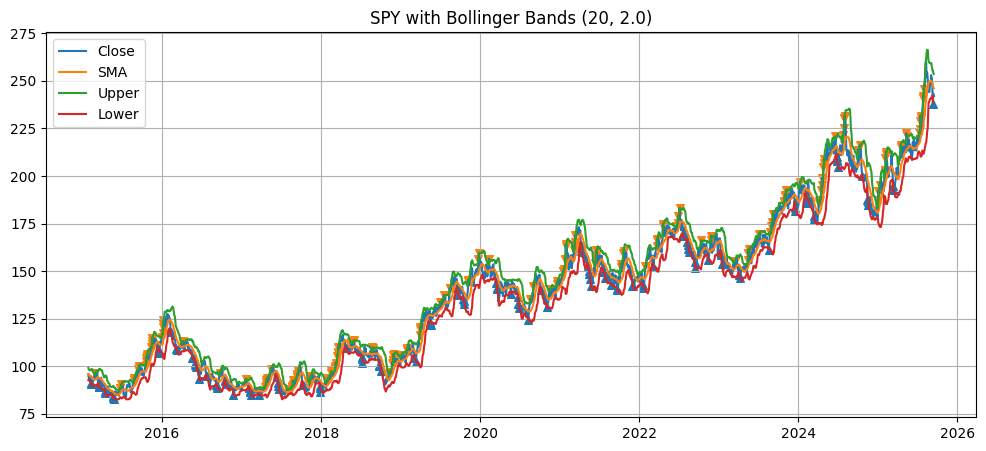

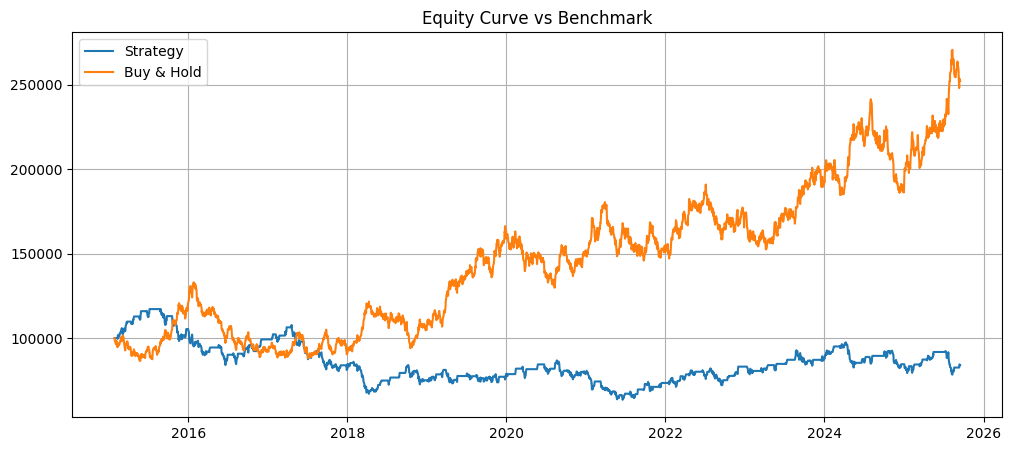

In [6]:
def plot_price_with_bands(df: pd.DataFrame):
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Close'], label='Close')
    ax.plot(df.index, df['sma'], label='SMA')
    ax.plot(df.index, df['upper'], label='Upper')
    ax.plot(df.index, df['lower'], label='Lower')

    long_entries = df['Close'] < df['lower']
    short_entries = df['Close'] > df['upper']
    ax.scatter(df.index[long_entries], df.loc[long_entries, 'Close'], marker='^', s=30)
    ax.scatter(df.index[short_entries], df.loc[short_entries, 'Close'], marker='v', s=30)
    ax.set_title(f"{TICKER} with Bollinger Bands ({BB_WINDOW}, {BB_K})")
    ax.legend(loc='best')
    plt.show()

def plot_equity_vs_benchmark(bt_df: pd.DataFrame, init_cash: float):
    bench = (1 + bt_df['ret']).cumprod() * init_cash
    fig, ax = plt.subplots()
    ax.plot(bt_df.index, bt_df['strat_equity'], label='Strategy')
    ax.plot(bt_df.index, bench, label='Buy & Hold')
    ax.set_title('Equity Curve vs Benchmark')
    ax.legend(loc='best')
    plt.show()

plot_price_with_bands(ind)
plot_equity_vs_benchmark(bt_df, INIT_CASH)

In [13]:
summary_df = pd.DataFrame([summary])
summary_path = 'bb_summary.csv'
trades_path  = 'bb_trades.csv'
summary_df.to_csv(summary_path, index=False)
trades.to_csv(trades_path, index=False)
print('Saved:', summary_path, 'and', trades_path)
summary_df

Saved: bb_summary.csv and bb_trades.csv


,ticker,period,bb_window,bb_k,init_cash,final_equity,CAGR,Sharpe,MaxDrawdown,NumTrades,WinRate,AvgTradePct,Costs_bps,Leverage,AllowShorts
0,SPY,2015-01-28 → 2025-09-15,20,2.0,100000,83939.924484,-0.015778,-0.04103,-0.458776,100,0.64,-0.001208,2,1.0,True
